In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/deep-learning-spring-2025-project-1/cifar_test_nolabel.pkl
/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/data_batch_1
/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/data_batch_2
/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/batches.meta
/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/test_batch
/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/data_batch_3
/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/data_batch_5
/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/data_batch_4
/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/readme.html


In [2]:
import pandas as pd
import pickle
import random
from torch.utils.data import DataLoader, random_split
from torchvision import transforms

def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

classes_dict = unpickle("/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/batches.meta")
label_names = classes_dict[b'label_names']
print(label_names)

# Load training data in batches, then combine
training_data = []
training_labels = []
for i in range(1, 6):
    training_fp = "/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/data_batch_{}".format(i)
    batch = unpickle(training_fp)
    batch_data = batch[b'data']
    batch_labels = batch[b'labels']
    for i in range(len(batch_data)):
        training_data.append(batch_data[i])
        training_labels.append(batch_labels[i])

print(len(training_data))
print(len(training_labels))

[b'airplane', b'automobile', b'bird', b'cat', b'deer', b'dog', b'frog', b'horse', b'ship', b'truck']
50000
50000


In [3]:
# def convert_to_rgb_tensor(image):
#     rgb_image = np.zeros((32, 32, 3), dtype=np.uint8)
#     red_idx, green_idx, blue_idx = 0, 1024, 2048
#     for row in range(0, 32):
#         for col in range(0, 32):
#             rgb_image[row, col] = [image[red_idx], image[green_idx], image[blue_idx]]
#             red_idx += 1
#             green_idx += 1
#             blue_idx += 1
    
#     rgb_tensor = transforms.ToTensor()(rgb_image)
#     return rgb_tensor

# Test on Random Image
# rand_num = random.randint(0, 10000)
# rand_image = data_batch_1[b'data'][rand_num]
# rand_image_rgb = convert_to_rgb(rand_image)

# rand_img_data = Image.fromarray(rand_image_rgb, 'RGB')
# img_data.save('test.png')
# label = data_batch_1[b'labels'][rand_num]
# print('Expected Image: ', label, '-', label_names[label])

# ADD VISUAL DISPLAY OF IMAGE HERE

In [4]:
# training_data = [convert_to_rgb_tensor(image) for image in training_data]
# training_data = np.array(training_data)
# training_labels = np.array(training_labels)

print(training_data[0].shape)
# Reshape the array to (N, 3, 32, 32), then rearrange to (N, 32, 32, 3)
training_data = np.array(training_data).reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
print(training_data[0].shape)

training_labels = np.array(training_labels)

# Transformation to tensor will switch to (3, 32, 32) - default convention in PyTorch
training_data = [(transforms.ToTensor()(image), label) for image, label in zip(training_data, training_labels)]
print(training_data[0][0].shape)

(3072,)
(32, 32, 3)
torch.Size([3, 32, 32])


In [5]:
training_count = int(0.8 * len(training_data))
validation_count = int(0.2 * len(training_data))

training_data, validation_data = random_split(training_data, [training_count, validation_count])

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

#Basic Residual Block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        #when in_channels != out_channels
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)  #residual connection
        out = self.relu(out)
        out = self.dropout(out)
        return out

class SimpleResNet(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = ResidualBlock(64, 64, stride=2)
        self.layer2 = ResidualBlock(64, 128, stride=2)
        self.layer3 = ResidualBlock(128, 256, stride=2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = self.dropout(out)
        out = torch.flatten(out, 1)
        return self.fc(out)

In [7]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleResNet().to(device)
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 16, 16]          36,864
       BatchNorm2d-5           [-1, 64, 16, 16]             128
            Conv2d-6           [-1, 64, 16, 16]          36,864
       BatchNorm2d-7           [-1, 64, 16, 16]             128
            Conv2d-8           [-1, 64, 16, 16]           4,096
       BatchNorm2d-9           [-1, 64, 16, 16]             128
             ReLU-10           [-1, 64, 16, 16]               0
          Dropout-11           [-1, 64, 16, 16]               0
    ResidualBlock-12           [-1, 64, 16, 16]               0
           Conv2d-13            [-1, 128, 8, 8]          73,728
      BatchNorm2d-14            [-1, 12

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# DataLoaders for Training, Validation
training_loader = DataLoader(training_data, batch_size=128, shuffle=True, num_workers=4)
validation_loader = DataLoader(validation_data, batch_size=128, shuffle=False, num_workers=4)

# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    
    model.train()
    running_loss = 0.0
    total_train_predictions = 0
    total_train_correct = 0

    for images, labels in training_loader:
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predictions = torch.max(outputs, dim=1)
        
        num_predictions = labels.size(dim=0)
        num_correct = (predictions == labels).sum().item()
        
        total_train_predictions += num_predictions
        total_train_correct += num_correct

    model.eval()
    total_val_predictions = 0
    total_val_correct = 0

    for images, labels in validation_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)

        _, predictions = torch.max(outputs, dim=1)

        num_predictions = labels.size(dim=0)
        num_correct = (predictions == labels).sum().item()

        total_val_predictions += num_predictions
        total_val_correct += num_correct

    print('Epoch {} - Training Loss: {}, Training Accuracy: {}%, Validation Accuracy: {}%'.format(epoch+1, running_loss / len(training_loader), total_train_correct * 100 / total_train_predictions, total_val_correct * 100 / total_val_predictions))

print("Training complete!")

Epoch 1 - Training Loss: 1.3684276593759799, Training Accuracy: 49.7325%, Validation Accuracy: 52.97%
Epoch 2 - Training Loss: 0.9598509202749965, Training Accuracy: 65.955%, Validation Accuracy: 66.21%
Epoch 3 - Training Loss: 0.7882766875976952, Training Accuracy: 72.0575%, Validation Accuracy: 71.02%
Epoch 4 - Training Loss: 0.6707721115491642, Training Accuracy: 76.175%, Validation Accuracy: 66.87%
Epoch 5 - Training Loss: 0.5822919641439908, Training Accuracy: 79.6225%, Validation Accuracy: 72.46%
Epoch 6 - Training Loss: 0.511318241159756, Training Accuracy: 81.9975%, Validation Accuracy: 78.23%
Epoch 7 - Training Loss: 0.45606026677087474, Training Accuracy: 83.8925%, Validation Accuracy: 74.06%
Epoch 8 - Training Loss: 0.39945117543680597, Training Accuracy: 85.7875%, Validation Accuracy: 76.78%
Epoch 9 - Training Loss: 0.34610083465949415, Training Accuracy: 87.7675%, Validation Accuracy: 79.42%
Epoch 10 - Training Loss: 0.3122431385917024, Training Accuracy: 88.895%, Validati

In [9]:
# Load test dataset
testing_fp = '/kaggle/input/deep-learning-spring-2025-project-1/cifar_test_nolabel.pkl'
testing_batch = unpickle(testing_fp)
testing_data = testing_batch[b'data']

print(testing_data[0].shape)

(32, 32, 3)


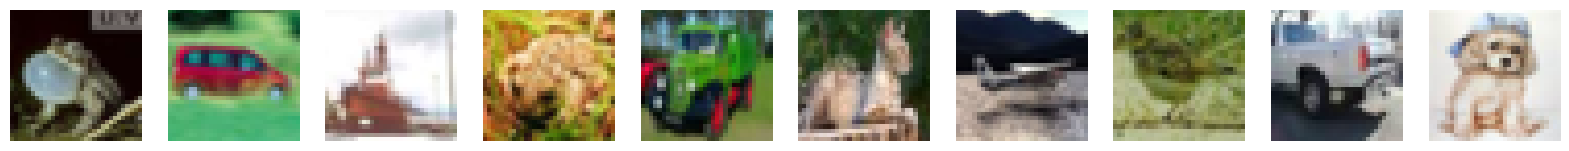

In [10]:
# Let's visualize some!

import matplotlib.pyplot as plt

# [0: airplane, 1: automobile, 2: bird, 3: cat, 4: deer, 5: dog, 6: frog, 7: horse, 8: ship, 9: truck]

# Display the first 10 images
plt.figure(figsize=(20, 4))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(testing_data[i])
    plt.axis('off')
plt.show()

# Testing --- So we should expect [6, 1, 8, 6, 9, 7, 8, 2, 9, 5]

In [11]:
# Changing to Tensor and adjusting shape before test
testing_data = [(transforms.ToTensor()(image),) for image in testing_data]
print(testing_data[0][0].shape)

# DataLoader
testing_loader = DataLoader(testing_data, batch_size=128, shuffle=False)

torch.Size([3, 32, 32])


In [12]:
## Final output is file called submission.csv with columns ID, Labels

model.eval()
test_predictions = []

with torch.no_grad():
    for batch in testing_loader:
        images = batch[0].to(device) 
        outputs = model(images) 
        _, predictions = torch.max(outputs, 1)
        
        # for prediction in predictions:
        #     test_predictions.append(prediction.item())
        test_predictions.extend(predictions.cpu().numpy())

test_predictions_dict = {'ID': np.arange(len(test_predictions)), 'Labels': test_predictions}
test_predictions_df = pd.DataFrame(test_predictions_dict)
test_predictions_df.to_csv('/kaggle/working/submission.csv', index=False)
print("Submitted! Check output for submission.csv")

Submitted! Check output for submission.csv
